In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
## Load the DataFrames
historical_mev = pd.read_csv('./data/HistoricalMEV.csv', parse_dates=['DATE'], infer_datetime_format=True)
forecasted_mev = pd.read_csv('./data/ForecastedMEV.csv', parse_dates=['DATE'], infer_datetime_format=True)
limit_data     = pd.read_csv('./data/ECLLimitData.csv', parse_dates=['AsOfDate'], date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%Y'))
ecl_data       = pd.read_csv('./data/ECLData.csv', parse_dates=['AS_OF_DATE'], infer_datetime_format=True)

limit_data['LimitMaturity'] = pd.to_datetime(limit_data['LimitMaturity'], format='%d/%m/%Y')
limit_data['AccountMaturity'] = pd.to_datetime(limit_data['AccountMaturity'], format='%d/%m/%Y')

In [3]:
for name, df in [('HistoricalMEV', historical_mev),
                 ('ForecastedMEV', forecasted_mev),
                 ('LimitData', limit_data),
                 ('ECLData', ecl_data)]:
    print(f"--- {name} sample rows ---")
    display(df.head(3))
    print()

--- HistoricalMEV sample rows ---


,DATE,GDP,HCPI,HPI
0,2013-01-31,2356788.67,95.71,106.60
1,2013-02-28,2376058.33,95.92,107.05
2,2013-03-31,2395328.00,95.98,107.70



--- ForecastedMEV sample rows ---


,SCENARIO,QUARTER,DATE,GDP,HCPI,HPI
0,BEST,Q1,2022-01-31,2770170.97,103.58,157.44
1,BEST,Q1,2022-02-28,2782303.83,102.64,157.49
2,BEST,Q1,2022-03-31,2794436.68,102.88,157.69



--- LimitData sample rows ---


,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31
1,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,NaN,9.06,1,2025-12-31,2025-12-31
2,2022-12-31,999999999999941,611267006,RP,574225.24,18832.65,NaN,7.34,1,2025-12-31,2025-06-30



--- ECLData sample rows ---


,AS_OF_DATE,CUSTOMER_ID,ACCOUNT_ID,SEGMENT,BUCKET,OUTSTANDING,INSTALMENT,EIR,REMAINING_TERM
0,2019-11-30,147172,551084402,HU,4,214547.19,9657.01,0.069394,0.0
1,2019-11-30,149971,551086221,HU,0,10791.57,11073.83,0.069394,1.0
2,2019-11-30,150521,551086536,HU,1,7541.94,9144.86,0.060789,0.0


In [4]:
# Missing-Value Inspection
for name, df in [
    ('HistoricalMEV', historical_mev),
    ('ForecastedMEV', forecasted_mev),
    ('ECLLimitData',  limit_data),
    ('ECLData',       ecl_data)
]:
    print(f"--- {name} missing counts ---")
    print(df.isnull().sum())
    print()

--- HistoricalMEV missing counts ---
DATE    0
GDP     0
HCPI    0
HPI     0
dtype: int64

--- ForecastedMEV missing counts ---
SCENARIO    0
QUARTER     0
DATE        0
GDP         0
HCPI        0
HPI         0
dtype: int64

--- ECLLimitData missing counts ---
AsOfDate            0
LimitID             0
AccountID           0
LoanType            0
Limit               0
Outstanding         0
Installment        13
EIR                 0
Stage               0
LimitMaturity       0
AccountMaturity     0
dtype: int64

--- ECLData missing counts ---
AS_OF_DATE        0
CUSTOMER_ID       0
ACCOUNT_ID        0
SEGMENT           0
BUCKET            0
OUTSTANDING       0
INSTALMENT        0
EIR               0
REMAINING_TERM    0
dtype: int64



In [5]:
# Compute remaining term in months (round to integer)
limit_data['RemainingTerm'] = (
    (limit_data['AccountMaturity'] - limit_data['AsOfDate'])
    / np.timedelta64(1, 'M')
).round().astype(int)

# Quick check
print("RemainingTerm sample:")
display(limit_data.head())

RemainingTerm sample:


,AsOfDate,LimitID,AccountID,LoanType,Limit,Outstanding,Installment,EIR,Stage,LimitMaturity,AccountMaturity,RemainingTerm
0,2022-12-31,999999999999941,611267004,TL,574225.24,167028.16,10443.93,6.58,1,2025-12-31,2024-01-31,13
1,2022-12-31,999999999999941,611267005,RP,574225.24,83661.58,NaN,9.06,1,2025-12-31,2025-12-31,36
2,2022-12-31,999999999999941,611267006,RP,574225.24,18832.65,NaN,7.34,1,2025-12-31,2025-06-30,30
3,2022-12-31,999999999999941,611267007,TL,574225.24,56400.00,3460.97,5.23,1,2025-12-31,2023-12-31,12
4,2022-12-31,999999999999941,611267008,TL,574225.24,24890.00,1346.45,5.26,1,2025-12-31,2023-08-31,8


In [6]:
# Convert annual EIR (%) to effective monthly rate
limit_data['annual_rate']  = limit_data['EIR'] / 100.0
limit_data['monthly_rate'] = (1 + limit_data['annual_rate'])**(1/12) - 1

# Annuity payment function using monthly_rate
def calculate_installment(principal, rate, periods):
    if periods <= 0:
        return np.nan
    if rate == 0:
        return principal / periods
    return (rate * principal) / (1 - (1 + rate)**(-periods))

# Impute missing installments
mask = limit_data['Installment'].isnull()
limit_data.loc[mask, 'Installment'] = limit_data[mask].apply(
    lambda r: calculate_installment(
        principal=r['Outstanding'],
        rate=r['monthly_rate'],
        periods=r['RemainingTerm']
    ), axis=1
)
limit_data['Installment_Imputed'] = mask.astype(int)

# Verify
print(f"Imputed {limit_data['Installment_Imputed'].sum()} rows")
display(limit_data.loc[limit_data['Installment_Imputed']==1,
                       ['LimitID','Outstanding','EIR','RemainingTerm','monthly_rate','Installment']])


Imputed 13 rows


,LimitID,Outstanding,EIR,RemainingTerm,monthly_rate,Installment
1,999999999999941,83661.580,9.06,36,0.007254,2648.913872
2,999999999999941,18832.650,7.34,30,0.005920,687.000834
6,999999999999948,43918.800,8.21,8,0.006597,5654.073697
7,999999999999948,57022.660,8.29,12,0.006659,4960.067747
8,999999999999948,38763.070,9.37,13,0.007492,3140.480422
9,999999999999979,67053.120,10.26,51,0.008172,1613.028622
13,999999999999979,16451.012,8.21,54,0.006597,363.119972
14,999999999999934,221799.090,10.66,3,0.008477,75189.979836
15,999999999999934,181834.020,6.75,12,0.005458,15695.789398
16,999999999999934,89552.300,6.65,39,0.005380,2551.655924


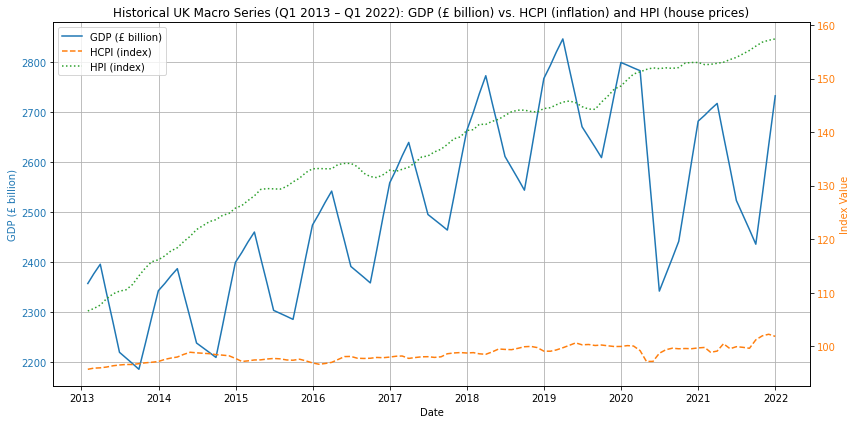

GDP (£ Billion)
These are quarterly estimates of the UK’s total output, measured in billions of pounds sterling.

HCPI (Index Value)
An HCPI reading of 100 in early 2013 means “prices at the base period.” By 2021 it’s risen to ~104, indicating roughly 4 % cumulative inflation since 2013

HPI (Index Value)
Starting at ~110 in 2013, it climbs steadily to ~158 by 2022, reflecting a ~41 % increase in average house prices over this period



In [7]:
# Plot historical macro variables over time

gdp_billion = historical_mev['GDP'] / 1_000

fig, ax1 = plt.subplots(figsize=(12,6))

# Plot GDP on left axis
ax1.plot(historical_mev['DATE'], gdp_billion, color='C0', label='GDP (£ billion)')
ax1.set_xlabel('Date')
ax1.set_ylabel('GDP (£ billion)', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')
ax1.grid(True)

# Create a second axis for the indices
ax2 = ax1.twinx()
ax2.plot(historical_mev['DATE'], historical_mev['HCPI'], label='HCPI (index)', linestyle='--', color='C1')
ax2.plot(historical_mev['DATE'], historical_mev['HPI'],  label='HPI (index)',  linestyle=':',  color='C2')
ax2.set_ylabel('Index Value', color='C1')
ax2.tick_params(axis='y', labelcolor='C1')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Historical UK Macro Series (Q1 2013 – Q1 2022): GDP (£ billion) vs. HCPI (inflation) and HPI (house prices)')
plt.tight_layout()
plt.show()



print("GDP (£ Billion)\nThese are quarterly estimates of the UK’s total output, measured in billions of pounds sterling.\n")
print("HCPI (Index Value)\nAn HCPI reading of 100 in early 2013 means “prices at the base period.” By 2021 it’s risen to ~104, indicating roughly 4 % cumulative inflation since 2013\n")
print("HPI (Index Value)\nStarting at ~110 in 2013, it climbs steadily to ~158 by 2022, reflecting a ~41 % increase in average house prices over this period\n")


Load Probability of Default‐related CSVs

1. **`cci.csv`** – monthly transition counts used to build a Credit Cycle Index (CCI).  
2. **`lifetimeMatrix.csv`** – marginal point-in-time PDs by segment and “month-in-life.”  
3. **`macroSignTransformed.csv`** – the macro indices (e.g. GDP, HCPI, HPI) transformed for CCI calibration.  
4. **`PDCurves.csv`** – the pre-calculated 12-month and lifetime PD curves for each segment.

In [8]:
cci_df          = pd.read_csv('./data/cci.csv', parse_dates=['Month'])
lt_matrix_df    = pd.read_csv('./data/lifetimeMatrix.csv')
macro_transf_df = pd.read_csv('./data/macroSignTransformed.csv')
pd_curves_df    = pd.read_csv('./data/PDCurves.csv')

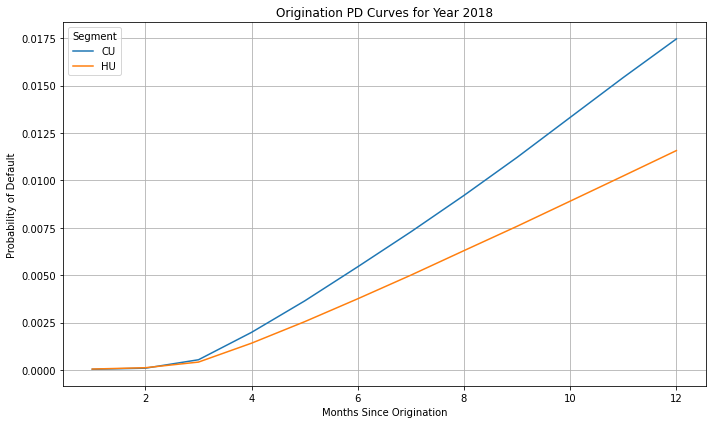

Lookup table:


Month,PD_12m,PD_Lifetime
Segment,,
CU,0.018116,0.080660
HU,0.012182,0.060913


In [9]:
# Filter for the 'Aging=0' slice (the PD path right at origination)
origin_curves = pd_curves_df[pd_curves_df['Aging'] == 0]

# Melt months 1–60 into a 'Month' column
months = [str(m) for m in range(1, 61)]
pd_long = origin_curves.melt(
    id_vars=['Segment', 'Year'],
    value_vars=months,
    var_name='Month',
    value_name='PD'
)

# Convert types
pd_long['Month'] = pd_long['Month'].astype(int)
pd_long['PD']    = pd_long['PD'].astype(float)

# Focus on the most recent Year
latest_year = pd_long['Year'].max()
pd_latest  = pd_long[pd_long['Year'] == latest_year]

# Plot one clean curve per segment
plt.figure(figsize=(10,6))
for seg, grp in pd_latest.groupby('Segment'):
    plt.plot(grp['Month'], grp['PD'], label=seg)
plt.xlabel('Months Since Origination')
plt.ylabel('Probability of Default')
plt.title(f'Origination PD Curves for Year {latest_year}')
plt.legend(title='Segment')
plt.grid(True)
plt.tight_layout()
plt.show()

# Build a segment-level lookup of PD_12m and PD_Lifetime (month 60) across all years
pd_lookup = (
    pd_long[pd_long['Month'].isin([12, 60])]
      .pivot_table(
          index='Segment',
          columns='Month',
          values='PD',
          aggfunc='max'       # take the max non-null PD across vintages
      )
      .rename(columns={12: 'PD_12m', 60: 'PD_Lifetime'})
)

print("Lookup table:")
display(pd_lookup)

In [10]:
pd_lookup = pd_lookup.reset_index().rename(columns={'Segment':'SEGMENT'})

# Merge back onto a fresh copy of the exposures
ecl = (
    ecl_data
    .merge(pd_lookup[['SEGMENT','PD_12m','PD_Lifetime']],
           on='SEGMENT', how='left')
)

# Correct PD assignment by dpd‐bucket → stage mapping:
#   BUCKET == 0 → Stage 1 → 12-month PD
#   BUCKET >= 1 → Stage 2/3 → lifetime PD
ecl['Assigned_PD'] = np.where(
    ecl['BUCKET'] == 0,
    ecl['PD_12m'],
    ecl['PD_Lifetime']
)

# Check the stats
print("Assigned_PD by BUCKET:")
print(ecl.groupby('BUCKET')['Assigned_PD'].describe())

Assigned_PD by BUCKET:
          count      mean       std       min       25%       50%       75%  \
BUCKET                                                                        
0       96466.0  0.014057  0.002759  0.012182  0.012182  0.012182  0.018116   
1       10025.0  0.068455  0.009595  0.060913  0.060913  0.060913  0.080660   
2        3652.0  0.068456  0.009596  0.060913  0.060913  0.060913  0.080660   
3         835.0  0.068055  0.009494  0.060913  0.060913  0.060913  0.080660   
4       18178.0  0.068717  0.009654  0.060913  0.060913  0.060913  0.080660   

             max  
BUCKET            
0       0.018116  
1       0.080660  
2       0.080660  
3       0.080660  
4       0.080660  


In [11]:
# Assign a placeholder LGD, flat 45%
ecl['LGD'] = 0.45

In [12]:
## Exposure at Default (EAD) - Bringing account’s credit limit and then 
## projecting how much of the undrawn portion will be drawn at default

limit_lookup = (
    limit_data
    .rename(columns={'AccountID':'ACCOUNT_ID', 'Limit':'CreditLimit'})
    [['ACCOUNT_ID','CreditLimit']]
    .drop_duplicates()
)


limit_lookup['ACCOUNT_ID'] = limit_lookup['ACCOUNT_ID'].astype(str)
ecl['ACCOUNT_ID']         = ecl['ACCOUNT_ID'].astype(str)

ecl = ecl.merge(limit_lookup, on='ACCOUNT_ID', how='left')

ecl['CreditLimit'] = ecl['CreditLimit'].fillna(ecl['OUTSTANDING'])

ecl['Undrawn'] = ecl['CreditLimit'] - ecl['OUTSTANDING']

# Flat Credit-Conversion Factor
ecl['CCF'] = 0.75

# Calculate EAD
ecl['EAD'] = ecl['OUTSTANDING'] + ecl['Undrawn'] * ecl['CCF']

print("After merge, non-null CreditLimits:", ecl['CreditLimit'].notnull().mean())
print(ecl[['OUTSTANDING','CreditLimit','Undrawn','CCF','EAD']].describe())


After merge, non-null CreditLimits: 1.0
        OUTSTANDING   CreditLimit        Undrawn        CCF           EAD
count  1.291560e+05  1.291560e+05  129156.000000  129156.00  1.291560e+05
mean   3.293269e+05  3.293340e+05       7.079598       0.75  3.293322e+05
std    2.048034e+05  2.048063e+05    1514.515062       0.00  2.048045e+05
min    1.226900e+02  1.226900e+02 -201201.690000       0.75  1.226900e+02
25%    1.754283e+05  1.754283e+05       0.000000       0.75  1.754283e+05
50%    3.218906e+05  3.218950e+05       0.000000       0.75  3.218950e+05
75%    4.383164e+05  4.383436e+05       0.000000       0.75  4.383402e+05
max    7.407989e+06  7.407989e+06  284716.150000       0.75  7.407989e+06


In [13]:
# Calculate ECL
ecl['annual_rate']  = ecl['EIR'] / 100.0
ecl['monthly_rate'] = (1 + ecl['annual_rate'])**(1/12) - 1

# Compute the discount factor over the remaining term
ecl['DiscountFactor'] = 1 / (1 + ecl['monthly_rate'])**ecl['REMAINING_TERM']

# Calculate the undiscounted ECL
ecl['ECL_undiscounted'] = ecl['Assigned_PD'] * ecl['LGD'] * ecl['EAD']

# Discount to present value
ecl['ECL'] = ecl['ECL_undiscounted'] * ecl['DiscountFactor']

# Aggregate results
total_ecl = ecl['ECL'].sum()
print(f"Total IFRS 9 allowance: £{total_ecl:,.2f}")

# Breakdown by stage
ecl_by_stage = ecl.groupby('BUCKET')['ECL'].sum()

ecl_pct_by_stage = (ecl_by_stage / total_ecl * 100).rename({
    0: 'Stage 1 (Performing)', 
    1: 'Stage 2 (30–59 dpd)', 
    2: 'Stage 2 (30–59 dpd)', 
    3: 'Stage 3 (60–89 dpd)', 
    4: 'Stage 3 (≥90 dpd)'
})

print("ECL by Stage (% of total):")
display(ecl_pct_by_stage)

Total IFRS 9 allowance: £618,229,175.45
ECL by Stage (% of total):


BUCKET
Stage 1 (Performing)    29.518223
Stage 2 (30–59 dpd)     16.630574
Stage 2 (30–59 dpd)      6.409619
Stage 3 (60–89 dpd)      1.519582
Stage 3 (≥90 dpd)       45.922001
Name: ECL, dtype: float64

In [14]:
# % of loans in each bucket
loan_counts = ecl['BUCKET'].value_counts(normalize=True).sort_index()*100
print("Loans by dpd-bucket (% of count):")
print(loan_counts)

# % of outstanding balance in each bucket
bal_share = (
    ecl.groupby('BUCKET')['OUTSTANDING']
       .sum()
       .div(ecl['OUTSTANDING'].sum())*100
)
print("\nOutstanding balance by bucket (% of total):")
print(bal_share)


Loans by dpd-bucket (% of count):
0    74.689523
1     7.761931
2     2.827588
3     0.646505
4    14.074453
Name: BUCKET, dtype: float64

Outstanding balance by bucket (% of total):
BUCKET
0    67.242157
1     7.750476
2     2.980160
3     0.712179
4    21.315028
Name: OUTSTANDING, dtype: float64


In [15]:
total_outstanding = ecl['OUTSTANDING'].sum()
print(f"Total amount loaned (outstanding principal): £{total_outstanding:,.2f}")

Total amount loaned (outstanding principal): £42,534,546,521.27


In [16]:
output_path = './data/ecl_results.csv' 
ecl.to_csv(output_path, index=False)